# The Lattice Boltzmann Method - unit conversion

This notebook uses the Lattice Boltzmann (LBM) Method for numerical simulation of
fluid flow to calculate the flow around a sphere. Written in python and jax. This
code will focus on converting relevant variables from physical to lattice units
and back.

The code is adjusted from the code presented by Machine Learning & Simulation (MLS) in 2D:
- On [Youtube](https://www.youtube.com/watch?v=ZUXmO4hu-20&list=LL&index=1&ab_channel=MachineLearning%26Simulation) and [Github](https://github.com/Ceyron/machine-learning-and-simulation/blob/main/english/simulation_scripts/lattice_boltzmann_method_python_jax.py)

Other notebookes on LBM:
- Expanded to 3D: [Google Colab](https://colab.research.google.com/drive/1F3EH9_2N3lkEpgQXOScR3lcQ6oqCARPk?usp=sharing) and [Github](https://github.com/Ceyron/machine-learning-and-simulation/blob/main/english/simulation_scripts/D3Q19_lattice_bolzmann_method_python_jax.py)
- on stress, force and force: [Google Colab](https://colab.research.google.com/drive/1oryCdOPXapOWxGSgCDNkvSUQ_MahfoRX?usp=sharing) and [Github](https://github.com/Ceyron/machine-learning-and-simulation/blob/main/english/simulation_scripts/D3Q19_lattice_boltzmann_method_stress_force_drag.py)
    
It is recommended to watch that video first and go through the notebook in 3D,
because a lot of explanation of this method, the setup and syntax mentioned in
that video and code will be skipped here. The force as determined in the relevant notebook/code will be used in the end of this code to convert force from lattice units to physical units.

In [19]:
import noise
import numpy as np

import jax
import jax.numpy as jnp
import time
from tqdm import tqdm
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython import display

# Enable 64bit
jax.config.update("jax_enable_x64", False) # Set to False for less used memory, but less accuracy

# Setup of the domain
The fluid flow simulation we are preparing is a sphere in fluid flow. The modelled domain is going to be 300 cells along the x-axis and 50 along the y- and z-axis. The fluid is going to flow into the domain from the left, where x = 0.



In [20]:
# Dimensions of domain in number of grid cells
nx = 256
ny = 256
nz = 32

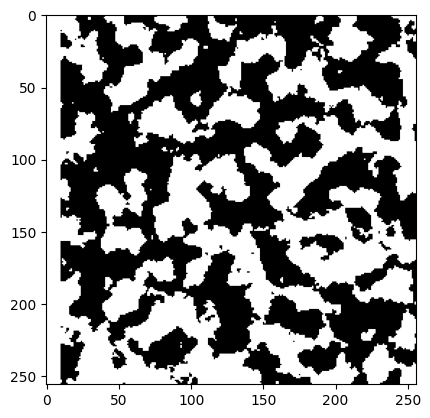

In [21]:
# Parameters
noise_scale = 0.05
seed = 0

# Set random seed for consistent results
np.random.seed(seed)

# Generate initial grain shape
grain = np.zeros((nx, ny, nz))

# Add Perlin noise to grain shape
for i in range(nx):
    for j in range(ny):
        for k in range(nz):
            x = i * noise_scale
            y = j * noise_scale
            z = k * noise_scale
            grain[i, j, k] = noise.pnoise3(x, y, z, octaves=4, persistence=0.5, lacunarity=2.0, repeatx=nx, repeaty=ny, repeatz=nz)

# Normalize the grain shape
grain = (grain - np.min(grain)) / (np.max(grain) - np.min(grain))
OBSTACLE_MASK = grain > 0.5
OBSTACLE_MASK[:10, ...] = False
# Plot the 3D grain shape
plt.imshow(OBSTACLE_MASK[..., nz//2].T, cmap="Greys")
plt.show()

## Unit conversion

The units of the grid are all in lattice units, which are not directly convertable to physical units. When you want to express your simulation in the physical world, it would be nice to show your results in centimeters, seconds and kilograms! For instance, we want to calculate the maximum flow around a sphere with a radius of 1 m in a domain that has a physical size much smaller than 300x50x50 of your chosen unit.

Below the distances for the domain in physical units are given. To distinguish variables in lattice and physical units, the denotation at the end of the variable will give a _L (or $_L$) for lattice and a _P (or $_P$) for physical units. The number of grid cells is the same in lattice and physical units of course and is omitted from this notation.

In [22]:
# Dimensions of domain in physical units: cm
xmin_P = ymin_P = zmin_P = 0
ymax_P = xmax_P = 10
zmax_P = xmax_P*nz/nx

To convert between lattice and physical units($L ↔ P$), one needs to define the distance between grid nodes in the physical space first.

$\Delta \alpha = L_{\alpha}^{P}/N_x$

Where L is the length of the domain in physical units Denoted with $^P$, and $N$ the number of grid cells in the subscripted axis $\alpha$. The length in lattice space is always 1!

In [23]:
ΔX_P = (xmax_P - xmin_P)/(nx)
ΔY_P = (ymax_P - ymin_P)/(ny)
ΔZ_P = (zmax_P - zmin_P)/(nz)

Besides length, units for time and mass are necessary for converting between physical and lattice units.  So next up is $L ↔ P$ for time! Time and space depend on each other in the physical space and time is dependant on the physical and lattice speed of sound $C_P$ and $C_L$:

$\Delta t = \frac{C_L}{C_P} \Delta x$

$C_L$ depents on the type of lattice you employ ([paper with good overview](https://terpconnect.umd.edu/~aydilek/papers/LB.pdf)) and $C_P$ will depend on the chosen fluid/gas. The $\Delta t$ is the amount of physical time between timesteps.

In [24]:
speed_of_sound_P  = 150000                                     # cm/s
speed_of_sound_L  = 1/(jnp.sqrt(3))
ΔT_P              = speed_of_sound_L / speed_of_sound_P * ΔX_P # in s
print(f'Δt = {ΔT_P :g} s')

Δt = 1.50352e-07 s


For simulations with a very small $\Delta x$, the $\Delta t$ will also be very small. Possibly to the point of impractically small timesteps. This can be carefully negated by setting a $\Delta t$ that is higher than set by above relationship. Carefully, because this raises the Mach number artificially. The Mach number ($Ma$):

$Ma = \frac{C_L}{C_P}$

Is one of the major stability and criteria and below a certain point (often around 0.2) no longer models physically incompressible fluids.

In [25]:
ΔT_P              = 1.6e-4
print(f'Δt = {ΔT_P :g} s')

Δt = 0.00016 s


In the cell below is the velocity ($v$ in $ms^{-1}$) defined, and also the viscosity ($\mu$ in $m^2s^{-1}$) defined. The values correspond to the sphere moving through honey, syrup or oil with no inconsiderable speed. The lattice units can be determined by dividing by the $\Delta x$ and $\Delta t$ corresponding by the variables units:

$\mu_L = \frac{\mu_P}{\frac{Δx^2}{Δt}} = \frac{\mu_PΔt}{Δx^2}$,
$\mu_P = \mu_L \frac{Δx^2}{Δt}$

$v_L = \frac{v_P}{\frac{Δx}{Δt}} = \frac{v_PΔt}{Δx}$,
$v_P = v_L \frac{Δx}{Δt}$

The dimensionless constant $Re$ does not change with conversion or the artificial raising of the Mach number, implying the flow regime will be the same with the raised Mach number.

In [26]:
# Physical parameters
KINEMATIC_VISCOSITY_P        = 0.01         # in cm²/s
HORIZONTAL_INFLOW_VELOCITY_P = .1           # in cm/s
_theoretical_grain_size_P = 10*10/256       # in cm

KINEMATIC_VISCOSITY_L        = KINEMATIC_VISCOSITY_P         / (ΔX_P**2 / ΔT_P)
HORIZONTAL_INFLOW_VELOCITY_L = HORIZONTAL_INFLOW_VELOCITY_P  / (ΔX_P / ΔT_P)
_theoretical_grain_size_L = _theoretical_grain_size_P * ΔX_P

# Estimate Reynolds number
reynolds_number_L = (HORIZONTAL_INFLOW_VELOCITY_L * 2 * _theoretical_grain_size_P) / KINEMATIC_VISCOSITY_L
reynolds_number_P = (HORIZONTAL_INFLOW_VELOCITY_P * 2 * _theoretical_grain_size_L) / KINEMATIC_VISCOSITY_P

mach_number_L = HORIZONTAL_INFLOW_VELOCITY_L / speed_of_sound_L
RELAXATION_OMEGA = (1.0 / (KINEMATIC_VISCOSITY_L/(speed_of_sound_L**2) + 0.5))

print(f'Lattice Reynolds number:  {reynolds_number_L: g}')
print(f'Physical Reynolds number: {reynolds_number_P: g}')
print(f'Mach number:              {mach_number_L: g}')
print(f'Relaxation time:          {1.0 /RELAXATION_OMEGA: g}')

Lattice Reynolds number:   0.305176
Physical Reynolds number:  0.305176
Mach number:               0.000709448
Relaxation time:           0.503146


That seem like reasonable $Re$, $Ma$ and $\tau$. If the Mach number get's too high, or the relaxation time ($\tau$) too low (too close to 0.5), consider a smaller $\Delta t_P$. The optimal variables differ for $Re$, object shape and boundary conditions and are often described as being found by trial and error. In [this](https://link.springer.com/book/10.1007/978-3-319-44649-3) book some more tips are given on getting the most out of your simulation.

Below, the number of seconds too be simulated is set. With the given $\Delta t_P$ the number of iterations is 18.750, which is ~2.5 times less than without artificially raising $Ma$. We assess the maximum velocity around the sphere at a steady state, which will develop after app. 2.5 seconds.

In [27]:
iterations_per_second = 1/ΔT_P
SECONDS_OF_SIMULATION = 2
NUMBER_OF_ITERATIONS = round(iterations_per_second * SECONDS_OF_SIMULATION)

# Define a mesh
x = jnp.arange(nx)
y = jnp.arange(ny)
z = jnp.arange(nz)
X, Y, Z = jnp.meshgrid(x, y, z, indexing="ij")
print('Number of iterations:', NUMBER_OF_ITERATIONS)

Number of iterations: 12500


Up last is mass, which is the easiest. It is inpendent from $\Delta x$ and $\Delta t$ and for convenience best practice the lattice density should be set to 1. Any amount of the physical unit of mass can than be prescribed to be the conversion factor. In this example, we stick to the honey-like $\mu$ and set the mass unit to 1400 / $\Delta x_P^3$, based on its density of 1400 $kg m^{-3}$. All three relevant conversion factors have been assigned, and a convenient function can be made where the units can be described and converted accordingly, which take the exponent of the relevant units:

In [28]:
density_P = 0.0014 # kg/cm³
ΔM_P = density_P * (ΔX_P ** 3)

def convert_to_lattice_units(value, length = 0, time = 0, mass = 0):
  return value * (ΔX_P ** -length) * (ΔT_P ** -time) * (ΔM_P ** -mass)

def convert_to_physical_units(value, length = 0, time = 0, mass = 0):
  return value * (ΔX_P ** length) * (ΔT_P ** time) * (ΔM_P ** mass)

density_L = convert_to_lattice_units(density_P, length = -3, time = 0, mass = 1)
print(f'Density: {density_P} in kg/m³ -> {density_L} in lattice units')

Density: 0.0014 in kg/m³ -> 1.0 in lattice units


$p_L = c_L^2 \rho_L$ 

$\rho_L = \frac{p_L}{c_L^2} = 3p_L$

In [29]:
base_pressure_P = convert_to_physical_units(1/3, mass = 1, length = -1, time = -2)
print("Pressure P:")
print(base_pressure_P, "kg/cms²")
print(base_pressure_P*1e4, "kg/ms² or Pa")
print(base_pressure_P/10, "bar")
print(base_pressure_P*1.45, "psi")

Pressure P:
27.815500895182282 kg/cms²
278155.0089518228 kg/ms² or Pa
2.781550089518228 bar
40.332476298014306 psi


In [30]:
pressure_difference = 1/18 # In kg/cms²
PRESSURE_IN_P = base_pressure_P + pressure_difference/2
PRESSURE_OUT_P = base_pressure_P - pressure_difference/2
PRESSURE_IN_L = convert_to_lattice_units(PRESSURE_IN_P, mass = 1, length = -1, time = -2)
PRESSURE_OUT_L = convert_to_lattice_units(PRESSURE_OUT_P, mass = 1, length = -1, time = -2)
DENSITY_IN_L = 3*PRESSURE_IN_L
DENSITY_OUT_L = 3*PRESSURE_OUT_L
print(DENSITY_IN_L - DENSITY_OUT_L)

0.001997287619047494


## Inititalization and relevant functions

The next few cells should look familiar, they are the implimentation for the LBM with BGK colission operator as seen in the previous notebook.

In [31]:
N_DISCRETE_VELOCITIES = 19

LATTICE_INDICES =     jnp.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9,10,11,12,13,14,15,16,17,18])
LATICE_VELOCITIES_X = jnp.array([0, 1,-1, 0, 0, 0, 0, 1,-1, 1,-1, 1,-1, 1,-1, 0, 0, 0, 0])
LATICE_VELOCITIES_Y = jnp.array([0, 0, 0, 1,-1, 0, 0, 1, 1,-1,-1, 0, 0, 0, 0, 1,-1, 1,-1])
LATICE_VELOCITIES_Z = jnp.array([0, 0, 0, 0, 0, 1,-1, 0, 0, 0, 0, 1, 1,-1,-1, 1, 1,-1,-1])

LATTICE_VELOCITIES = jnp.array([LATICE_VELOCITIES_X,
                                LATICE_VELOCITIES_Y,
                                LATICE_VELOCITIES_Z])

LATTICE_WEIGHTS = jnp.array([# rest particle
                             1/3,

                             # face-connected neighbors
                             1/18, 1/18, 1/18, 1/18, 1/18, 1/18,

                             # edge-connected neighbors
                             1/36, 1/36, 1/36, 1/36, 1/36, 1/36, 1/36, 1/36, 1/36, 1/36, 1/36, 1/36])

OPPOSITE_LATTICE_INDICES = jnp.array([jnp.where((LATTICE_VELOCITIES.T == -LATTICE_VELOCITIES[:, i]).all(axis = 1))[0] for i in range(N_DISCRETE_VELOCITIES)]).T[0]

RIGHT_VELOCITIES =       jnp.where(LATICE_VELOCITIES_X == 1)[0] # [ 1,  7,  9, 11, 13]
LEFT_VELOCITIES =        jnp.where(LATICE_VELOCITIES_X ==-1)[0] # [ 2,  8, 10, 12, 14]
YZ_VELOCITIES =          jnp.where(LATICE_VELOCITIES_X ==0)[0] # [ 0,  3,  4,  5,  6, 15, 16, 17, 18]
YZ_VELOCITIES_Y_POS =    jnp.where((LATICE_VELOCITIES_X == 0) & (LATICE_VELOCITIES_Y == 1))[0] # [ 3, 15, 17]
YZ_VELOCITIES_Y_NEG =    jnp.where((LATICE_VELOCITIES_X == 0) & (LATICE_VELOCITIES_Y == -1))[0] # [ 4, 16, 18]
XZ_VELOCITIES_Z_POS =    jnp.where((LATICE_VELOCITIES_X == 0) & (LATICE_VELOCITIES_Z == 1))[0] # [ 5, 15, 16]
XZ_VELOCITIES_Z_NEG =    jnp.where((LATICE_VELOCITIES_X == 0) & (LATICE_VELOCITIES_Z == -1))[0] # [ 6, 17, 18]

In [32]:
XZ_VELOCITIES_Z_NEG

Array([ 6, 17, 18], dtype=int32)

In [33]:
M = jnp.array([ [  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
                [-30,-11,-11,-11,-11,-11,-11,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8],
                [ 12, -4, -4, -4, -4, -4, -4,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
                [  0,  1, -1,  0,  0,  0,  0,  1, -1,  1, -1,  1, -1,  1, -1,  0,  0,  0,  0],
                [  0, -4,  4,  0,  0,  0,  0,  1, -1,  1, -1,  1, -1,  1, -1,  0,  0,  0,  0],
                [  0,  0,  0,  1, -1,  0,  0,  1,  1, -1, -1,  0,  0,  0,  0,  1, -1,  1, -1],
                [  0,  0,  0, -4,  4,  0,  0,  1,  1, -1, -1,  0,  0,  0,  0,  1, -1,  1, -1],
                [  0,  0,  0,  0,  0,  1, -1,  0,  0,  0,  0,  1,  1, -1, -1,  1,  1, -1, -1],
                [  0,  0,  0,  0,  0, -4,  4,  0,  0,  0,  0,  1,  1, -1, -1,  1,  1, -1, -1],
                [  0,  2,  2, -1, -1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1, -2, -2, -2, -2],
                [  0, -4, -4,  2,  2,  2,  2,  1,  1,  1,  1,  1,  1,  1,  1, -2, -2, -2, -2],
                [  0,  0,  0,  1,  1, -1, -1,  1,  1,  1,  1, -1, -1, -1, -1,  0,  0,  0,  0],
                [  0,  0,  0, -2, -2,  2,  2,  1,  1,  1,  1, -1, -1, -1, -1,  0,  0,  0,  0],
                [  0,  0,  0,  0,  0,  0,  0,  1, -1, -1,  1,  0,  0,  0,  0,  0,  0,  0,  0],
                [  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1, -1, -1,  1],
                [  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1, -1, -1,  1,  0,  0,  0,  0],
                [  0,  0,  0,  0,  0,  0,  0,  1, -1,  1, -1, -1,  1, -1,  1,  0,  0,  0,  0],
                [  0,  0,  0,  0,  0,  0,  0, -1, -1,  1,  1,  0,  0,  0,  0,  1, -1,  1, -1],
                [  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1, -1, -1, -1, -1,  1,  1]])
M_inv = jnp.linalg.inv(M)

s1 = 1.19
s2 = s10 = 1.4
s4 = 1.2
s16 = 1.98
s9 = s13 = RELAXATION_OMEGA

S = jnp.eye(N_DISCRETE_VELOCITIES) * jnp.array([0, s1, s2, 0, s4, 0, s4, 0, s4, s9, s10, s9, s10, s13, s13, s13, s16, s16, s16])

COLLISION_OPERATOR = M_inv @ S @ M

In [34]:
@jax.jit
def get_density(discrete_velocities):
    density = jnp.sum(discrete_velocities, axis=-1)
    return density

@jax.jit
def get_macroscopic_velocities(discrete_velocities, density):
    return jnp.einsum("...Q,dQ->...d", discrete_velocities, LATTICE_VELOCITIES) / density[..., jnp.newaxis]

@jax.jit
def get_equilibrium_discrete_velocities(macroscopic_velocities, density):
    projected_discrete_velocities = jnp.einsum("dQ,...d->...Q", LATTICE_VELOCITIES, macroscopic_velocities)
    macroscopic_velocity_magnitude = jnp.linalg.norm(macroscopic_velocities, axis=-1, ord=2)
    equilibrium_discrete_velocities = (density[..., jnp.newaxis] * LATTICE_WEIGHTS[jnp.newaxis, jnp.newaxis, jnp.newaxis, :] *
        (1 + 3 * projected_discrete_velocities + 9/2 * projected_discrete_velocities**2 -
        3/2 * macroscopic_velocity_magnitude[..., jnp.newaxis]**2))
    return equilibrium_discrete_velocities

VELOCITY_PROFILE = jnp.zeros((nx, ny, nz, 3))
VELOCITY_PROFILE = VELOCITY_PROFILE.at[:, :, :, 0].set(HORIZONTAL_INFLOW_VELOCITY_L)
discrete_velocities_prev = get_equilibrium_discrete_velocities(VELOCITY_PROFILE,
                                                               jnp.ones((nx, ny, nz)))

## Boundary conditions
$$u_x = 1 - \frac{1}{3p}\left(\sum_{e_x=0}f_i + 2\sum_{e_x=-1}f_i\right)$$

$$f1 = f2 + pu_x$$

## Velocity in action

In [35]:
@jax.jit
def update(discrete_velocities_prev):
    # (2) Determine macroscopic velocities
    density_prev = get_density(discrete_velocities_prev)
    macroscopic_velocities_prev = get_macroscopic_velocities(
        discrete_velocities_prev,
        density_prev)

    # (3) Prescribe inflow/outflow pressure BC using Zou/He scheme in 3D:
    density_prev = density_prev.at[0, ..., :].set(DENSITY_IN_L)
    lateral_densities = get_density(jnp.einsum('i...->...i', discrete_velocities_prev[0, ..., YZ_VELOCITIES]))
    left_densities = get_density(jnp.einsum('i...->...i', discrete_velocities_prev[0, ..., LEFT_VELOCITIES]))
    macroscopic_velocities_prev = macroscopic_velocities_prev.at[0, ..., 0].set(
        1 - (
        lateral_densities + 
        2*left_densities
        )/DENSITY_IN_L
    )

    density_prev = density_prev.at[-1, ..., :].set(DENSITY_OUT_L)
    lateral_densities = get_density(jnp.einsum('i...->...i', discrete_velocities_prev[-1, ..., YZ_VELOCITIES]))
    left_densities = get_density(jnp.einsum('i...->...i', discrete_velocities_prev[-1, ..., LEFT_VELOCITIES]))
    macroscopic_velocities_prev = macroscopic_velocities_prev.at[-1, ..., 0].set(
        (
        lateral_densities + 
        2*left_densities
        )/DENSITY_OUT_L - 1
    )
    
    # (4) Compute discrete Equilibria velocities
    equilibrium_discrete_velocities = get_equilibrium_discrete_velocities(
       macroscopic_velocities_prev,
       density_prev)

    # (3) Belongs to the Zou/He scheme
    discrete_velocities_prev =\
          discrete_velocities_prev.at[0, ..., RIGHT_VELOCITIES].set(
              equilibrium_discrete_velocities[0, ..., RIGHT_VELOCITIES])

    # (5) Collide according to MRT
    discrete_velocities_post_collision = (discrete_velocities_prev -
                                          jnp.einsum('...Q, PQ-> ...P',
                                                     discrete_velocities_prev -
                                                     equilibrium_discrete_velocities,
                                          (COLLISION_OPERATOR)))

    # (6) Bounce-Back Boundary Conditions to enfore the no-slip
    for i in range(N_DISCRETE_VELOCITIES):
        discrete_velocities_post_collision = discrete_velocities_post_collision.at[OBSTACLE_MASK, LATTICE_INDICES[i]].set(
                                                      discrete_velocities_prev[OBSTACLE_MASK, OPPOSITE_LATTICE_INDICES[i]])

    # (7) Stream alongside lattice velocities
    discrete_velocities_streamed = discrete_velocities_post_collision
    for i in range(N_DISCRETE_VELOCITIES):
        discrete_velocities_streamed = discrete_velocities_streamed.at[1:, ..., i].set(
            jnp.roll(
                discrete_velocities_post_collision[..., i],
                LATTICE_VELOCITIES[:, i], axis = (0, 1, 2)
            )[1:, ...]
        )

    return discrete_velocities_streamed


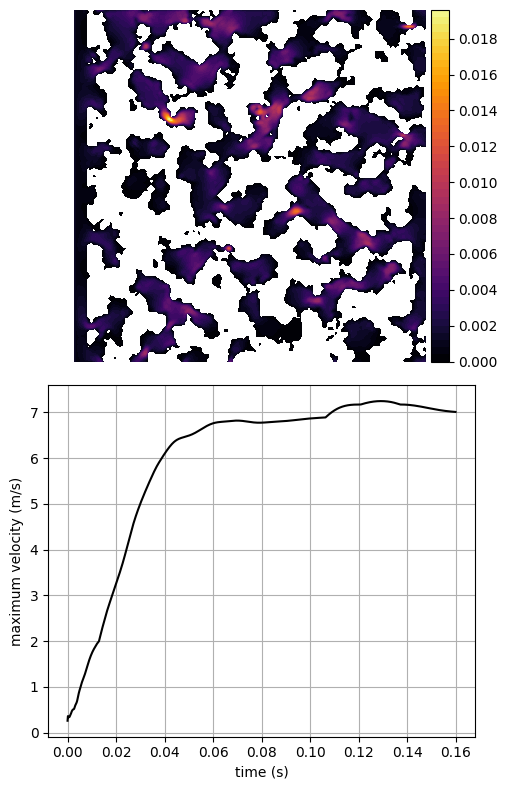

  9%|██████▋                                                                       | 1081/12500 [01:07<11:04, 17.19it/s]

In [ ]:
PLOT_EVERY_N_STEP = 100
SKIP_FIRST_N = 0
def run(discrete_velocities_prev):
        maximum_velocity_L = []
        
        for i in tqdm(range(NUMBER_OF_ITERATIONS)):
            discrete_velocities_next = update(discrete_velocities_prev)
            discrete_velocities_prev = discrete_velocities_next

            density_L = get_density(discrete_velocities_next)
            macroscopic_velocities_L = get_macroscopic_velocities(
                discrete_velocities_next,
                density_L)
            velocity_magnitude_L = jnp.linalg.norm(
                macroscopic_velocities_L,
                axis=-1,
                ord=2)
            maximum_velocity_L.append(jnp.max(velocity_magnitude_L))
            velocity_magnitude_L = velocity_magnitude_L.at[OBSTACLE_MASK].set(jnp.nan)
            if i % PLOT_EVERY_N_STEP == 0 and i > SKIP_FIRST_N - PLOT_EVERY_N_STEP:
                fig, axs = plt.subplots(2, 1, figsize = (5, 8))
                contour = axs[0].contourf(X[..., nz//2], Y[...,  nz//2],
                             velocity_magnitude_L[...,  nz//2],
                             alpha=1, levels=50,  vmax = 0.02, cmap="inferno")
                axs[0].axis('equal')
                axs[0].axis('off')
                divider = make_axes_locatable(axs[0])
                cax = divider.append_axes('right', size='5%', pad=0.05)
                plt.colorbar(contour, cax=cax, orientation='vertical')
                

                time_P = jnp.linspace(0,
                                    convert_to_physical_units(
                                        i,
                                        time = 1),
                                    i+1)

                maximum_velocity_P = convert_to_physical_units(
                    jnp.array(maximum_velocity_L),
                    length = 1,
                    time = -1
                )

                # print(len(maximum_velocity_P))
                axs[1].plot(time_P, maximum_velocity_P, c = 'k')
                axs[1].set_xlabel('time (s)')
                axs[1].set_ylabel('maximum velocity (m/s)')
                axs[1].grid()

                plt.tight_layout()
                display.clear_output(wait=True)
                display.display(fig)
                plt.close(fig)
                time.sleep(0.01)
        return discrete_velocities_next
discrete_velocities = run(discrete_velocities_prev)

## The results
The graph shows us the maximum physical velocity in our domain. It starts off at the initial velocity we defined (10 m/s in the example) and then increases rapidly. Over time the maximum velocity decreases until it stabilizes around the 2.5 seconds mark.

Due to some unphysical behaviour the velocity starts off quite erratic but soon becomes a smoother curve.

## Force
In a previous notebook, the momentum exchange method was used to determine force. The method described there shows the results for force in lattice units. With the discrete velocities returned from the funciton we can calculate the force in lattice units, and convert them to physical units.

First we get the lattice units:

In [ ]:
MOMENTUM_EXCHANGE_MASK_IN  = jnp.zeros((nx, ny, nz, 19)) > 0
MOMENTUM_EXCHANGE_MASK_OUT = jnp.zeros((nx, ny, nz, 19)) > 0

for i, (x, y, z) in enumerate(LATTICE_VELOCITIES.T):
  # Determine the momentum going into the object:
  location_in = jnp.logical_and(
              jnp.roll(
                  jnp.logical_not(OBSTACLE_MASK),
                  (x, y, z),
                  axis = (0, 1, 2)),
              OBSTACLE_MASK)

  MOMENTUM_EXCHANGE_MASK_IN = MOMENTUM_EXCHANGE_MASK_IN.at[location_in, i].set(True)

  # Determine the momentum going out of the object:
  location_out = jnp.logical_and(
              jnp.roll(
                  OBSTACLE_MASK,
                  (-x, -y, -z),
                  axis = (0, 1, 2)),
              jnp.logical_not(OBSTACLE_MASK))

  MOMENTUM_EXCHANGE_MASK_OUT = MOMENTUM_EXCHANGE_MASK_OUT.at[location_out, OPPOSITE_LATTICE_INDICES[i]].set(True)

force_L = jnp.sum(
                  (LATTICE_VELOCITIES.T[jnp.newaxis, jnp.newaxis, jnp.newaxis, ...] *
                   discrete_velocities[..., jnp.newaxis])[MOMENTUM_EXCHANGE_MASK_IN] +
                   (LATTICE_VELOCITIES.T[OPPOSITE_LATTICE_INDICES][jnp.newaxis, jnp.newaxis, jnp.newaxis, ...] *
                    discrete_velocities[..., jnp.newaxis])[MOMENTUM_EXCHANGE_MASK_OUT],
                  axis = 0)

And then we convert to physical units (in $kg^1 m^1 s^{-2}$):

In [ ]:
force_P = convert_to_physical_units(force_L,
                                    mass = 1,
                                    length = 1,
                                    time = -2)

print(f'Force over the horizontal axis: {force_P[0]: ,g} kg⋅m/s²')